<!-- <div style="background-color: rgb(247, 230, 202); border: 4px solid rgb(162, 87, 79); border-radius: 40px; padding: 20px; font-family: 'Roboto'; color: rgb(162, 87, 79); text-align: left; font-size: 120%;">
    <ul style="list-style-type: square; padding-left: 20px;">
        <li style="margin-top: 10px;">HLA columns are recalculated as per <a href="https://www.kaggle.com/code/albansteff/cibmtr-eda-ensemble-model-recalculate-hla" style="color: #A2574F; text-decoration: underline;">this</a> notebook.</li>
        <li style="margin-top: 10px;">Missing values are replaced with:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <li>-1 for numeric columns</li>
                <li>Unknown for categorical columns</li>
            </ul>
        </li>
        <li style="margin-top: 10px;">
            LightGBM and CatBoost are trained on 3 different targets, estimated from the survival models:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <li>Cox</li>
                <li>Kaplan-Meier</li>
                <li>Nelson-Aalen</li>
            </ul>
        </li>
        <li style="margin-top: 10px;">Two additional CatBoost model are trained, with Cox loss function.</li>
        <li style="margin-top: 10px;">As per <a href="https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/553061" style="color: #A2574F; text-decoration: underline;">this</a> discussion post, the target is consisted of the Out-of-Fold predictions of the survival models on the validation folds to prevent target leakage.</li>
        <li style="margin-top: 10px;">
            The ensemble prediction for each sample is computed as:
            <ul style="list-style-type: circle; margin-top: 10px; margin-bottom: 10px;">
                <p style="margin-top: 10px; font-size: 110%; color: #A2574F; font-family: 'Roboto'; text-align: left;">
                    $ \text{preds}_{\text{ensemble}} = \sum_{i=1}^{n} w_i \cdot \text{rankdata}(\text{preds}_i) $
                </p>
                where $n$ is the number of models, $w_i$ is the weight assigned to the $i$-th model, and $\text{rankdata}(\text{preds}_i)$ is the rank of predictions from the $i$-th model.
            </ul>
        </li>
        <li style="margin-top: 10px;">Last but not least, since the competition metric evaluates only the order of predictions and not their magnitude, the model weights are not required to sum to 1, nor should the predictions fall within a predefined range.</li>
    </ul>
</div> -->

<p style="font-size: 150%; text-align: left; border-radius: 40px 40px; color: rgb(232, 95, 9); font-weight: bold;">Notebookから引用</p>  

リンク：https://www.kaggle.com/code/andreasbis/cibmtr-eda-ensemble-model

<p style="font-size: 120%; text-align: left; border-radius: 40px 40px; color: rgb(244, 62, 7); font-weight: bold;">
概要
</p>  

- 特徴量エンジニアリング
    - 特徴量作成
        - ``hla_high_xxx``や``hla_low_xxx``といった特徴量は自分で作り直す
- 欠損値補完
    - 数値列は``-1``
    - カテゴリ列は``Unknown``
- モデル
    - 種類（計８つのモデル）
        - ２つの予測モデル（LightGBMとCatBoost）×３つの生存確率推定モデル
            - コックス比例ハザードモデル
                - モデル概要
                    - セミパラメトリックモデル
                    - 共変量（複数の説明変数）を考慮できる
                    - 返す値は「相対的なリスクの大きさ」
                - データ処理
                    - １値しか取らないカラムを削除
                    - カテゴリ変数について``one hot encoding``を実施
            - カプラン・マイヤー推定量
                - ノンパラメトリックモデル（データからそのまま推定・特定の確率分布を仮定しない）
                - 共変量を考慮しない単純な推定
                - 生存確率を計算（０〜１）
                $$
                \begin{align*}
                S(t) &= \prod_{t_i \leq t} \left( 1 - \frac{d_i}{n_i} \right)  
                \end{align*}
                $$

                $$
                \begin{align*}
                t_i &\text{ はイベント発生時点} \\
                d_i &\text{ はその時点でのイベント発生個体数} \\
                n_i &\text{ はその時点での生存個体数}
                \end{align*}
                $$
            - ネルソン・アーレン推定量
                - ノンパラメトリックモデル（データからそのまま推定・特定の確率分布を仮定しない）
                - 共変量を考慮しない単純な推定
                - 累積ハザード確率を計算（０〜１）
                $$
                \begin{align*}
                H(t) &= \sum_{t_i \leq t} \frac{d_i}{n_i}
                \end{align*}
                $$
                $$
                \begin{align*}
                t_i &\text{ はイベント発生時点} \\
                d_i &\text{ はその時点でのイベント発生個体数} \\
                n_i &\text{ はその時点での生存個体数}
                \end{align*}
                $$
            - カプラン・マイヤーとネルソン・アーレンの違い
                - 「死亡のイベントが発生した時間に関数値が変化するという性質」は共通
                - ネルソン・アーレンは、「小さいサイズの標本に対してよりよい性質をもつ」
        - CatBoost（木の深さ優先 / 損失減少優先）× Cox回帰に基づく損失関数
            - CatBoost
                - ハイパーパラメータの設定の違い（木の深さ優先 / 損失減少優先）により2種類作成
                - 損失関数として「Cox回帰」を指定
            - Cox回帰に基づく損失関数
                - targetの設定
                    - 特定のイベントが発生せずに生存している期間を測定する指標を用いる
                    - イベントが発生しなかったデータについては生存時間を負にすることで、イベントが発生しなかったデータポイントを明確に区別できる
                - 予測モデル
                    - CatBoostにおいて、Cox回帰に基づく損失関数を使用
    - 特徴
        - ターゲットリークを防ぐため、ターゲットは検証フォールドにおけるサバイバルモデルのOut-of-Fold予測で構成される
            - https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/553061
        - アンサンブル予測は各サンプルについて以下のように計算される
            - アンサンブル予測 = Σ(wi * rankdata(predsi)) 
                - ここで、wiは i 番目のモデルに割り当てられた重み（<font color = "red">分析者が指定</font>）
                - rankdata(predsi)は i 番目のモデルの予測のランク
            - 競争メトリックが予測の大きさではなく順序のみを評価するため、モデルの重みは1に合計する必要はなく、予測も予め定義された範囲内である必要はありません。
- 精度評価
    - 層別C統計量を使用
        - 元のノートブックではmetricライブラリのscore関数を使用していたが、利用できないので代替
        - 層別C統計量は以前から使用していたもの


<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">ライブラリ</p>

In [47]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import polars as pl #ライブラリのインポートに非常に時間がかかりそうだったので割愛
# import plotly.colors as pc
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = 'iframe'

# 生存関数推定モデル
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines.utils import concordance_index #C-indexの計算

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# 予測モデル
import lightgbm as lgb
import optuna
from catboost import CatBoostRegressor
from scipy.stats import rankdata

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">データインポート</p>

In [48]:
# INPUT_DIRにディレクトリを指定
INPUT_DIR = "xxx"
pd.options.display.max_columns = None

In [49]:
# !pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
# !pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
# !pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">パラメータ設定【CFG】</p>

重みや正則化パラメータは自分で決定

In [50]:
# クラス変数（クラス全体で共有される変数）の定義
class CFG:
    # train_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/train.csv') 
    # test_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/test.csv') 
    # subm_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv') 
    train_path = INPUT_DIR + "train.csv"
    test_path = INPUT_DIR + "test.csv"
    subm_path = INPUT_DIR + "sample_submission.csv"

    # colorscale = 'red' # 可視化に使用するカラースケールの指定
    color = '#A2574F' # 可視化に使用するカラーパレットの指定

    early_stop = 300 # 早期終了のパラメータ（一定エポック改善がない場合に終了）
    penalizer = 0.01 # 正則化パラメータの設定
    n_splits = 5 # クロスバリデーションの分割数

    weights = [2, 1, 6, 3, 6, 3, 6, 6] # 特定のモデルやデータに対する重みのリスト

    ctb_params = { # CatBoostモデルのハイパーパラメータ
        'loss_function': 'RMSE', # 損失関数としてRMSEを使用
        'learning_rate': 0.03, # 学習率
        'random_state': 42, # 乱数シード
        'task_type': 'CPU', # モデルをCPUで実行
        'num_trees': 6000, # 決定木の数
        'reg_lambda': 8.0, # L2正則化の強さ
        'depth': 8 # 決定木の深さ
    }

    lgb_params = { # LightGBMモデルのハイパーパラメータ
        'objective': 'regression', # 回帰タスクを指定
        'min_child_samples': 32, # ノードごとの最小データ数
        'num_iterations': 6000, # イテレーション回数
        'learning_rate': 0.03, # 学習率
        'extra_trees': True, # Extra Trees方式を使用
        'reg_lambda': 8.0, # L2正則化の強さ
        'reg_alpha': 0.1, # L1正則化の強さ
        'num_leaves': 64, # 決定木の葉の数
        'metric': 'rmse', # 評価指標としてRMSEを使用
        'max_depth': 8, # 決定木の深さの最大値
        'device': 'cpu', # モデルをCPUで実行
        'max_bin': 128, # ビンの最大数
        'verbose': -1, # ログ出力の抑制
        'seed': 42 # 乱数シード
    }

    cox1_params = { # Coxモデルのハイパーパラメータ（Depthwiseの成長ポリシー）
        'grow_policy': 'Depthwise', # 木の深さに基づいた成長ポリシー （デフォルトは"SymmetricTree"（対照ツリー））
        'min_child_samples': 8, # ノードごとの最小データ数
        'loss_function': 'Cox', # 損失関数としてCox回帰を使用
        'learning_rate': 0.03, # 学習率
        'random_state': 42, # 乱数シード
        'task_type': 'CPU', # モデルをCPUで実行
        'num_trees': 6000, # 決定木の数
        'reg_lambda': 8.0, # L2正則化の強さ
        'depth': 8 # 決定木の深さ
    }

    cox2_params = { # Coxモデルのハイパーパラメータ（Lossguideの成長ポリシー）
        'grow_policy': 'Lossguide', # データ損失に基づいた成長ポリシー
        'min_child_samples': 2, # ノードごとの最小データ数
        'loss_function': 'Cox', # 損失関数としてCox回帰を使用
        'learning_rate': 0.03, # 学習率
        'random_state': 42, # 乱数シード
        'task_type': 'CPU', # モデルをCPUで実行
        'num_trees': 6000, # 決定木の数
        'reg_lambda': 8.0, # L2正則化の強さ
        'num_leaves': 32, # 決定木の葉の数
        'depth': 8 # 決定木の深さ
    }

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">特徴量エンジニアリング【FE】</p>

In [51]:
class FE:
    def __init__(self):
        pass # 初期化メソッドには何も処理を行わない

    def _load_data(self, path):
        df = pd.read_csv(path)
        return df

    def _update_hla_columns(self, df): # "hla_high_xxx"、"hla_low_xxx"系の特徴量について、既知のデータを用いずに自分で作成
        df['hla_nmdp_6'] = (
            df['hla_match_a_low'].fillna(0)
            + df['hla_match_b_low'].fillna(0)
            + df['hla_match_drb1_high'].fillna(0)
        )
        df['hla_low_res_6'] = (
            df['hla_match_a_low'].fillna(0)
            + df['hla_match_b_low'].fillna(0)
            + df['hla_match_drb1_low'].fillna(0)
        )
        df['hla_high_res_6'] = (
            df['hla_match_a_high'].fillna(0)
            + df['hla_match_b_high'].fillna(0)
            + df['hla_match_drb1_high'].fillna(0)
        )
        df['hla_low_res_8'] = (
            df['hla_match_a_low'].fillna(0)
            + df['hla_match_b_low'].fillna(0)
            + df['hla_match_c_low'].fillna(0)
            + df['hla_match_drb1_low'].fillna(0)
        )
        df['hla_high_res_8'] = (
            df['hla_match_a_high'].fillna(0)
            + df['hla_match_b_high'].fillna(0)
            + df['hla_match_c_high'].fillna(0)
            + df['hla_match_drb1_high'].fillna(0)
        )
        df['hla_low_res_10'] = (
            df['hla_match_a_low'].fillna(0)
            + df['hla_match_b_low'].fillna(0)
            + df['hla_match_c_low'].fillna(0)
            + df['hla_match_drb1_low'].fillna(0)
            + df['hla_match_dqb1_low'].fillna(0)
        )
        df['hla_high_res_10'] = (
            df['hla_match_a_high'].fillna(0)
            + df['hla_match_b_high'].fillna(0)
            + df['hla_match_c_high'].fillna(0)
            + df['hla_match_drb1_high'].fillna(0)
            + df['hla_match_dqb1_high'].fillna(0)
        )
        return df

    def _cast_datatypes(self, df): # 欠損値の補完
        num_cols = [
            'hla_high_res_8', 'hla_low_res_8', 'hla_high_res_6', 'hla_low_res_6',
            'hla_high_res_10', 'hla_low_res_10', 'hla_match_dqb1_high',
            'hla_match_dqb1_low', 'hla_match_drb1_high', 'hla_match_drb1_low',
            'hla_nmdp_6', 'year_hct', 'hla_match_a_high', 'hla_match_a_low',
            'hla_match_b_high', 'hla_match_b_low', 'hla_match_c_high',
            'hla_match_c_low', 'donor_age', 'age_at_hct', 'comorbidity_score',
            'karnofsky_score', 'efs', 'efs_time'
        ]
        for col in df.columns:
            if col in num_cols:
                df[col] = df[col].fillna(-1).astype('float32') # 数値型の場合は欠損値を-1で補完
            else:
                df[col] = df[col].fillna('Unknown').astype('category') # カテゴリ型の場合は欠損値を'Unknown'で補完
        df['ID'] = df['ID'].astype('int32') # データ型の変更
        return df

    def info(self, df): #データフレームのメモリ使用量を確認
        print(f'\nShape of dataframe: {df.shape}')
        mem = df.memory_usage().sum() / 1024**2
        print('Memory usage: {:.2f} MB\n'.format(mem))
        print(df.head())

    def apply_fe(self, path): # 上記関数の適用
        df = self._load_data(path) # pathのデータを読み込む
        df = self._update_hla_columns(df) # hla_high_xxx、hla_low_xxx系の特徴量を追加
        df = self._cast_datatypes(df) # 欠損値の補完
        self.info(df) # データフレームのメモリ確認
        cat_cols = [col for col in df.columns if df[col].dtype == 'category']
        return df, cat_cols

In [52]:
# インスタンス作成
fe = FE()

In [53]:
# 
df_train, cat_cols = fe.apply_fe(CFG.train_path)


Shape of dataframe: (28800, 60)
Memory usage: 3.72 MB

   ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No       Unknown       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No       Unknown       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No       Unknown       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0              -1.0             6.0              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_iss

In [54]:
test_data, _ = fe.apply_fe(CFG.test_path)


Shape of dataframe: (3, 58)
Memory usage: 0.00 MB

      ID                       dri_score psych_disturb    cyto_score diabetes  \
0  28800  N/A - non-malignant indication            No       Unknown       No   
1  28801                    Intermediate            No  Intermediate       No   
2  28802  N/A - non-malignant indication            No       Unknown       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0              -1.0             6.0              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_issue pulm_severe  \
0            6.0       Bone marrow        No          No          No   
1            6.0  Peripheral blood        No          No          No   
2            6.0       Bone marrow        No          No          No   

  prim_disease_hct  hla_high_res_6 cmv_status  hla_hi

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">可視化【EDA】</p>

In [55]:
class EDA:
    def __init__(self, color, data):
        # self._colorscale = sns.color_palette(colorscale)
        self._color = color
        self.data = data

    def _template(self, ax, title):
        ax.set_title(title, fontsize=16, color=self._color, ha='center')
        # ax.set_facecolor('rgba(247, 230, 202, 1)')
        ax.grid(True, axis='x', color='grey', linestyle='-', linewidth=0.5)
        ax.grid(True, axis='y', color='grey', linestyle='-', linewidth=0.5)
        ax.tick_params(axis='both', colors=self._color)
        ax.set_xlabel('Values', color=self._color)
        ax.set_ylabel('Count', color=self._color)
        return ax

    def distribution_plot(self, col, title):
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.histplot(self.data[col], bins=100, color=self._color, ax=ax)
        ax = self._template(ax, f'{title}')
        plt.show()

    def bar_chart(self, col):
        value_counts = self.data[col].value_counts().reset_index()
        value_counts.columns = [col, 'count']

        fig, ax = plt.subplots(figsize=(8, 6))
        sns.barplot(data=value_counts, x='count', y=col, ax=ax)

        ax = self._template(ax, f'{col}')
        ax.set_xlabel('Count')
        ax.set_ylabel('')
        plt.show()

    def _plot_cv(self, scores, title, metric='Stratified C-Index'):
        fold_scores = [round(score, 3) for score in scores]
        mean_score = round(np.mean(scores), 3)

        fig, ax = plt.subplots(figsize=(8, 6))

        ax.scatter(range(1, len(fold_scores) + 1), fold_scores, color=self._color, s=100, label='Fold Scores', marker='D')

        ax.plot([1, len(fold_scores)], [mean_score, mean_score], color='#B22222', linestyle='--', label=f'Mean: {mean_score:.3f}')
        
        ax.set_title(f'{title} | Cross-validation Mean {metric} Score: {mean_score}', fontsize=16, color=self._color, ha='center')
        ax.set_xlabel('Fold', color=self._color)
        ax.set_ylabel(f'{metric} Score', color=self._color)
        
        ax.legend()
        ax.set_xticks(range(1, len(fold_scores) + 1))
        ax.set_ylim(min(fold_scores) - 0.05, max(fold_scores) + 0.05)

        ax = self._template(ax, f'{title} Cross-validation')
        plt.show()

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">生存確率（目的変数）の推定【Targets】</p>

特徴的な点  
- カテゴリ変数にone hot encodingを実施
- cvにおいて一つの値しか取らないカラムを削除

In [56]:
class Targets:
    def __init__(self, data, cat_cols, penalizer, n_splits):
        self.data = data
        self.cat_cols = cat_cols
        self._length = len(self.data)
        self._penalizer = penalizer
        self._n_splits = n_splits

    def _prepare_cv(self): # cvのためのデータ分割
        oof_preds = np.zeros(self._length)
        cv = KFold(n_splits=self._n_splits, shuffle=True, random_state=42)
        return cv, oof_preds

    def score(self, df_true, df_prediction, event_label, interval_label, prediction_label): #層別C-indexの計算
        # ID列を削除
        del df_true["ID"]
        del df_prediction["ID"]

        merged_df = pd.concat([df_true, df_prediction], axis=1)
        merged_df.reset_index(inplace=True)
        merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups) # 人種ごとに該当するデータのインデックスを辞書形式で保管
        metric_list = []
        for race in merged_df_race_dict.keys(): #人種ごと
            indices = sorted(merged_df_race_dict[race]) #該当する人種のインデックスを取得
            merged_df_race = merged_df.iloc[indices] # 該当するインデックスのデータを取得
            c_index_race = concordance_index( # concordance_indexはefs, efs_time, predicton（生存確率）からC-indexを計算
                merged_df_race[interval_label],
                -merged_df_race[prediction_label], # 符号を反転（通常 C-Index は「リスクが高いほど短命」と仮定するため）
                merged_df_race[event_label])
            metric_list.append(c_index_race)
        return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

    def validate_model(self, preds, title):
        y_true = self.data[['ID', 'efs', 'efs_time', 'race_group']].copy()
        y_pred = self.data[['ID']].copy()
        y_pred['prediction'] = preds
        c_index_score = self.score(y_true.copy(), y_pred.copy(), "efs", "efs_time", "prediction")
        print(f'Overall Stratified C-Index Score for {title}: {c_index_score:.4f}')

    def create_target1(self): # Cox比例ハザードモデル
        '''
        Constant columns are dropped if they exist in a fold. Otherwise, the code produces error:
        delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: 
        https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
        '''
        cv, oof_preds = self._prepare_cv() #データ分割
        data = pd.get_dummies(self.data, columns=self.cat_cols, drop_first=True).drop('ID', axis=1) # カテゴリ変数にone hot encodingを実施

        for fold, (train_index, valid_index) in enumerate(cv.split(data), 1):
            df_train = data.iloc[train_index]
            valid_data = data.iloc[valid_index]
            unique_columns = df_train.nunique() > 1
            removed_columns = df_train.columns[~unique_columns] # 一つの値しか取らないカラムを削除
            df_train = df_train.loc[:, unique_columns]
            valid_data = valid_data[df_train.columns]
            print(f"Fold {fold}:")
            print(f"Removed columns: {list(removed_columns)}") # 削除されたカラムとその数を表示
            print(f"Number of removed columns: {len(removed_columns)}")
            cph = CoxPHFitter(penalizer=self._penalizer) # Cox比例ハザードモデルのインスタンス作成（penalizer：正則化の強さ（過学習を防止する目的））
            cph.fit(df_train, duration_col='efs_time', event_col='efs')
            oof_preds[valid_index] = cph.predict_partial_hazard(valid_data)

        self.data['target1'] = oof_preds
        self.validate_model(oof_preds, 'Cox')
        return self.data

    def create_target2(self): # Kaplan-Meier生存関数モデル
        cv, oof_preds = self._prepare_cv() #データ分割

        for train_index, valid_index in cv.split(self.data):
            df_train = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]
            kmf = KaplanMeierFitter()
            kmf.fit(durations=df_train['efs_time'], event_observed=df_train['efs'])
            oof_preds[valid_index] = kmf.survival_function_at_times(valid_data['efs_time']).values

        self.data['target2'] = oof_preds
        self.validate_model(oof_preds, 'Kaplan-Meier')

        return self.data

    def create_target3(self): # Nelson-Aalen生存関数モデル
        cv, oof_preds = self._prepare_cv()
        for train_index, valid_index in cv.split(self.data):
            df_train = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]
            naf = NelsonAalenFitter()
            naf.fit(durations=df_train['efs_time'], event_observed=df_train['efs'])
            oof_preds[valid_index] = -naf.cumulative_hazard_at_times(valid_data['efs_time']).values

        self.data['target3'] = oof_preds
        self.validate_model(oof_preds, 'Nelson-Aalen')
        return self.data

    def create_target4(self): # 
        self.data['target4'] = self.data.efs_time.copy()
        self.data.loc[self.data.efs == 0, 'target4'] *= -1
        return self.data

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">モデル構築【MD】</p>

In [57]:
class MD:
    def __init__(self,color, data, cat_cols, early_stop, penalizer, n_splits):
        self.eda = EDA(color, data) # EDAクラスのインスタンス作成
        self.targets = Targets(data, cat_cols, penalizer, n_splits) # Targetsクラスのインスタンス作成
        self.data = data
        self.cat_cols = cat_cols
        self.early_stop = early_stop

    def create_targets(self): # 4種類の生存確率
        self.data = self.targets.create_target1()
        self.data = self.targets.create_target2()
        self.data = self.targets.create_target3()
        self.data = self.targets.create_target4()
        return self.data

    def score(self, df_true, df_prediction, event_label, interval_label, prediction_label): #層別C-indexの計算
        # ID列を削除
        del df_true["ID"]
        del df_prediction["ID"]

        merged_df = pd.concat([df_true, df_prediction], axis=1)
        merged_df.reset_index(inplace=True)
        merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups) # 人種ごとに該当するデータのインデックスを辞書形式で保管
        metric_list = []
        for race in merged_df_race_dict.keys(): #人種ごと
            indices = sorted(merged_df_race_dict[race]) #該当する人種のインデックスを取得
            merged_df_race = merged_df.iloc[indices] # 該当するインデックスのデータを取得
            c_index_race = concordance_index( # concordance_indexはefs, efs_time, predicton（生存確率）からC-indexを計算
                merged_df_race[interval_label],
                -merged_df_race[prediction_label], # 符号を反転（通常 C-Index は「リスクが高いほど短命」と仮定するため）
                merged_df_race[event_label])
            metric_list.append(c_index_race)
        return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

    def train_model(self, params, target, title):
        for col in self.cat_cols:
            self.data[col] = self.data[col].astype('category')
        X = self.data.drop(['ID', 'efs', 'efs_time', 'target1', 'target2', 'target3', 'target4'], axis=1)
        y = self.data[target]
        models, fold_scores = [], []
        cv, oof_preds = self.targets._prepare_cv()
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
            X_train = X.iloc[train_index]
            X_valid = X.iloc[valid_index]
            y_train = y.iloc[train_index]
            y_valid = y.iloc[valid_index]
            if title.startswith('LightGBM'):
                model = lgb.LGBMRegressor(**params)
                model.fit(
                    X_train,
                    y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    callbacks=[lgb.early_stopping(self.early_stop, verbose=0), lgb.log_evaluation(0)]
                )
            elif title.startswith('CatBoost'):
                model = CatBoostRegressor(**params, verbose=0, cat_features=self.cat_cols)
                model.fit(
                    X_train,
                    y_train,
                    eval_set=(X_valid, y_valid),
                    early_stopping_rounds=self.early_stop, 
                    verbose=0
                )
            models.append(model) # モデルのリストに追加
            oof_preds[valid_index] = model.predict(X_valid) # 予測値を格納

            y_true_fold = self.data.iloc[valid_index][['ID', 'efs', 'efs_time', 'race_group']].copy()
            y_pred_fold = self.data.iloc[valid_index][['ID']].copy()
            y_pred_fold['prediction'] = oof_preds[valid_index] # 予測値を格納

            fold_score = self.score(y_true_fold, y_pred_fold, "efs", "efs_time", "prediction")
            fold_scores.append(fold_score) # スコアのリストに追加
        self.eda._plot_cv(fold_scores, title)
        self.targets.validate_model(oof_preds, title)
        return models, oof_preds

    def infer_model(self, data, models):
        data = data.drop(['ID'], axis=1)
        for col in self.cat_cols: # カテゴリ変数をcategory型に変換
            data[col] = data[col].astype('category')
        return np.mean([model.predict(data) for model in models], axis=0)

In [58]:
# MDクラスのインスタンス作成
md = MD(CFG.color, df_train, cat_cols, CFG.early_stop, CFG.penalizer, CFG.n_splits)

In [59]:
df_train = md.create_targets()

Fold 1:
Removed columns: []
Number of removed columns: 0
Fold 2:
Removed columns: ['gvhd_proph_FK+- others(not MMF,MTX)']
Number of removed columns: 1
Fold 3:
Removed columns: []
Number of removed columns: 0
Fold 4:
Removed columns: []
Number of removed columns: 0
Fold 5:
Removed columns: []
Number of removed columns: 0
Overall Stratified C-Index Score for Cox: 0.6564
Overall Stratified C-Index Score for Kaplan-Meier: 0.9983
Overall Stratified C-Index Score for Nelson-Aalen: 0.9983


各推定量のC統計量のうち、Cox比例ハザードモデルものが低い原因（あくまでも推定）
- 過学習を防ぐ目的で`_penalizer`を追加しているため？？
> Overall Stratified C-Index Score for Cox: 0.6564  
> Overall Stratified C-Index Score for Kaplan-Meier: 0.9983  
> Overall Stratified C-Index Score for Nelson-Aalen: 0.9983  


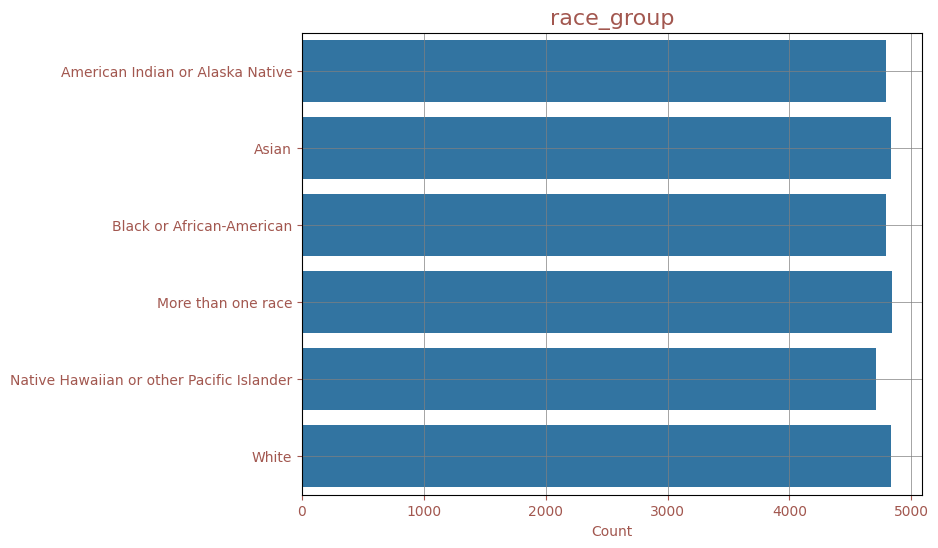

In [60]:
md.eda.bar_chart('race_group')

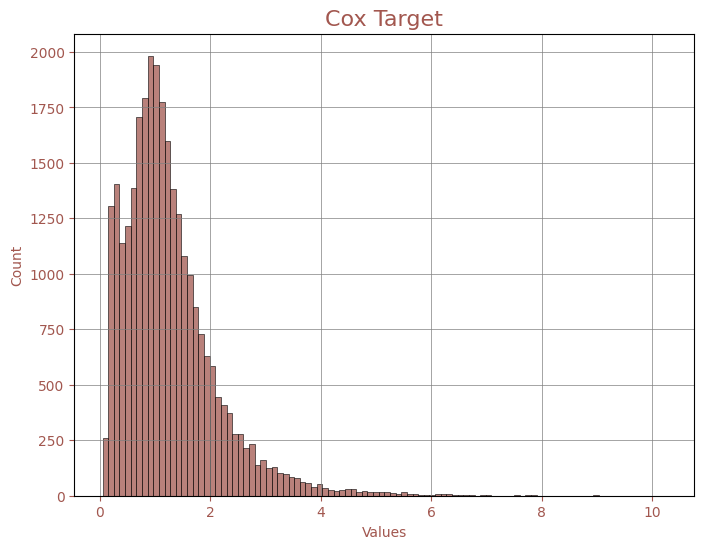

In [61]:
md.eda.distribution_plot('target1', 'Cox Target')

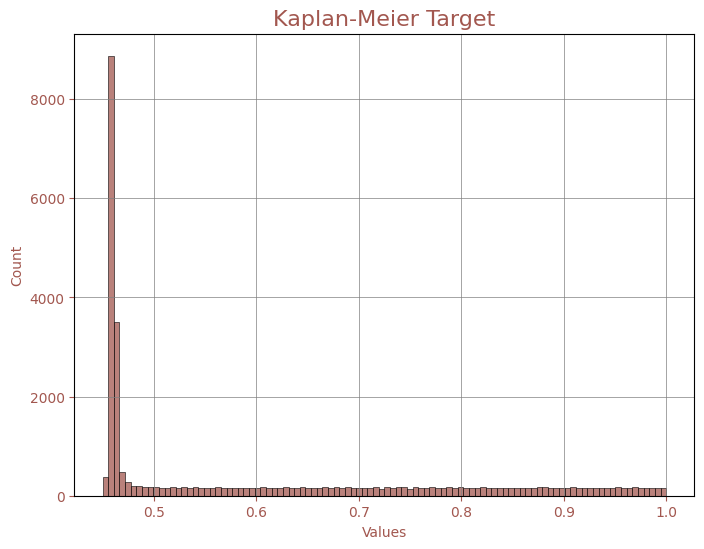

In [62]:
md.eda.distribution_plot('target2', 'Kaplan-Meier Target')

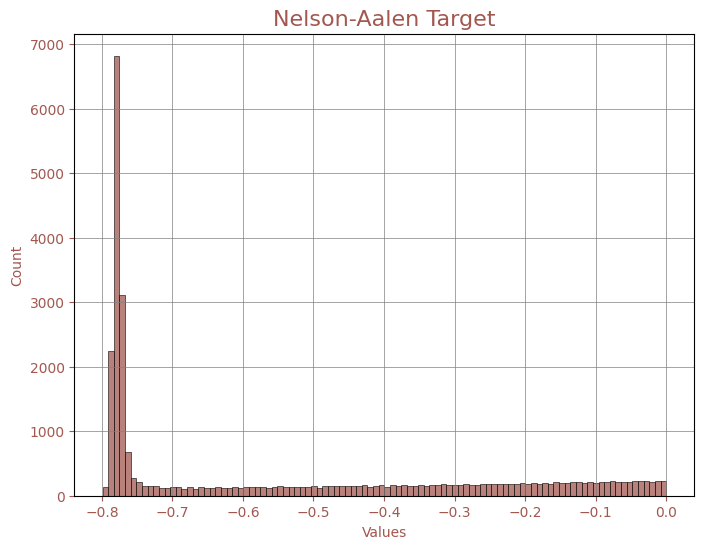

In [63]:
md.eda.distribution_plot('target3', 'Nelson-Aalen Target')

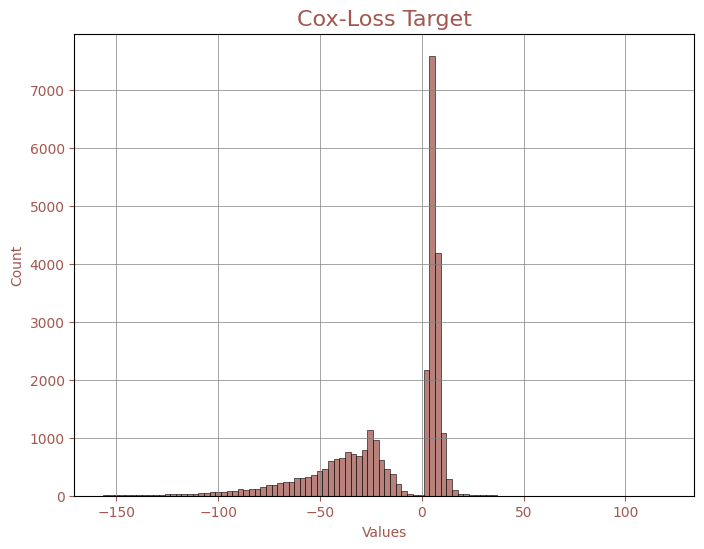

In [64]:
md.eda.distribution_plot('target4', 'Cox-Loss Target')

In [65]:
fe.info(df_train)


Shape of dataframe: (28800, 64)
Memory usage: 4.49 MB

   ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No       Unknown       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No       Unknown       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No       Unknown       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0              -1.0             6.0              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6        graft_type vent_hist renal_iss

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">Cox比例ハザードモデルによる予測</p>

- 目的変数
    - target1
- 予測モデル
    - lgbm
    - catboost

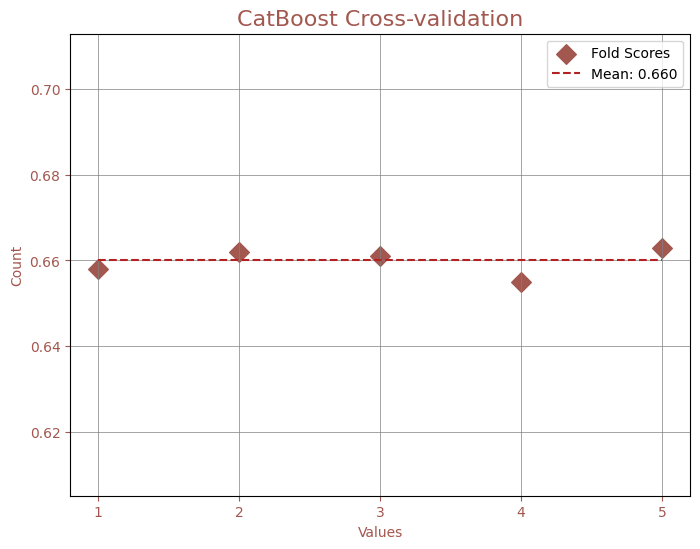

Overall Stratified C-Index Score for CatBoost: 0.6614


In [66]:
# CatBoost
ctb1_models, ctb1_oof_preds = md.train_model(CFG.ctb_params, target='target1', title='CatBoost')

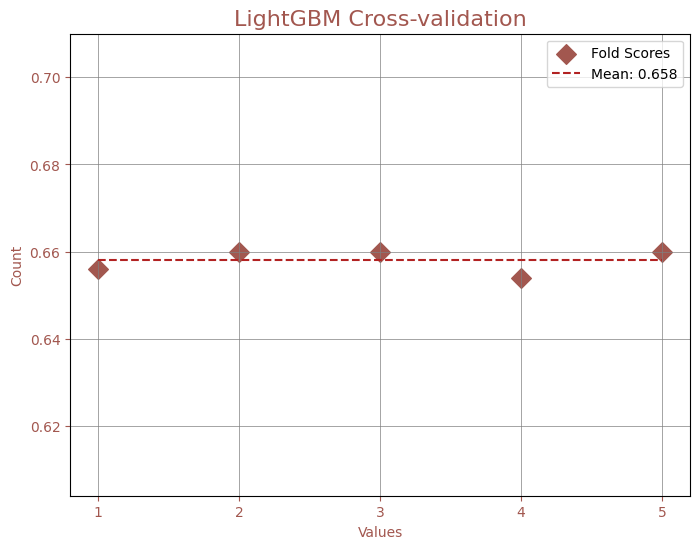

Overall Stratified C-Index Score for LightGBM: 0.6596


In [67]:
# LightGBM
lgb1_models, lgb1_oof_preds = md.train_model(CFG.lgb_params, target='target1', title='LightGBM')

In [68]:
ctb1_preds = md.infer_model(test_data, ctb1_models)

In [69]:
lgb1_preds = md.infer_model(test_data, lgb1_models)

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">カプラン・マイヤー推定量による予測</p>

- 目的変数
    - target2
- 予測モデル
    - lgbm
    - catboost

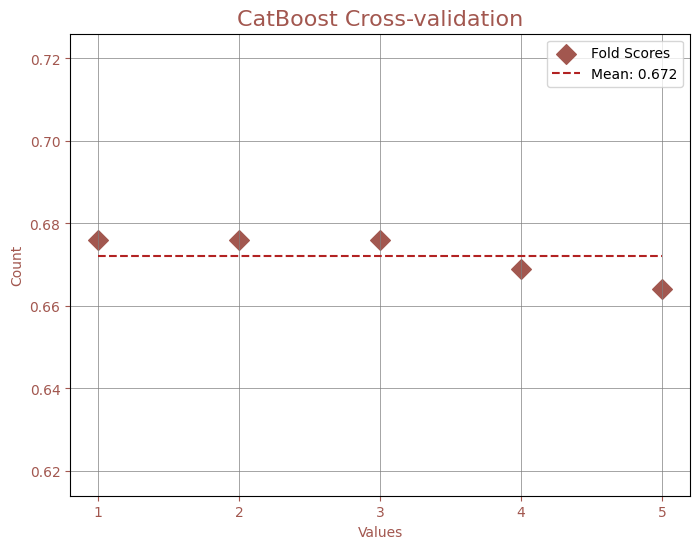

Overall Stratified C-Index Score for CatBoost: 0.6748


In [70]:
ctb2_models, ctb2_oof_preds = md.train_model(CFG.ctb_params, target='target2', title='CatBoost')

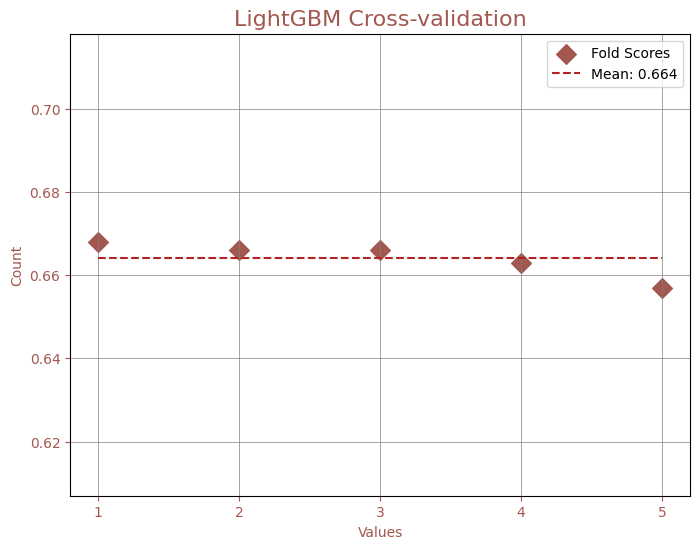

Overall Stratified C-Index Score for LightGBM: 0.6668


In [71]:
lgb2_models, lgb2_oof_preds = md.train_model(CFG.lgb_params, target='target2', title='LightGBM')

In [72]:
ctb2_preds = md.infer_model(test_data, ctb2_models)

In [73]:
lgb2_preds = md.infer_model(test_data, lgb2_models)

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">ネルソン・アーレン推定量による予測</p>

- 目的変数
    - target3
- 予測モデル
    - lgbm
    - catboost

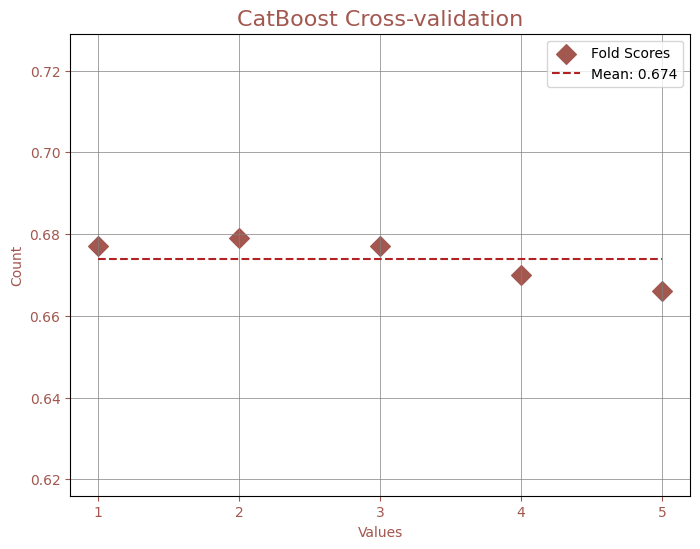

Overall Stratified C-Index Score for CatBoost: 0.6766


In [74]:
ctb3_models, ctb3_oof_preds = md.train_model(CFG.ctb_params, target='target3', title='CatBoost')

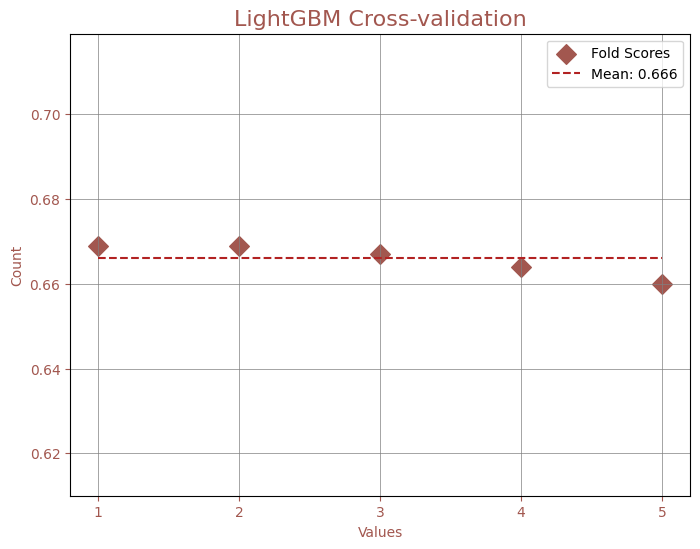

Overall Stratified C-Index Score for LightGBM: 0.6691


In [75]:
lgb3_models, lgb3_oof_preds = md.train_model(CFG.lgb_params, target='target3', title='LightGBM')

In [76]:
ctb3_preds = md.infer_model(test_data, ctb3_models)

In [77]:
lgb3_preds = md.infer_model(test_data, lgb3_models)

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">Cox-Lossによる予測</p>

- 目的変数
    - target4
- 予測モデル
    - catboost
        - 木の深さ優先
        - 損失最小優先

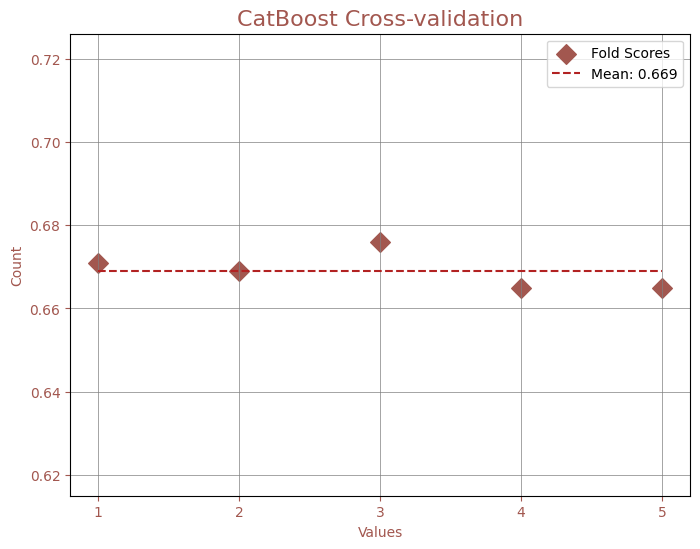

Overall Stratified C-Index Score for CatBoost: 0.6705


In [78]:
# 木の深さ優先
cox1_models, cox1_oof_preds = md.train_model(CFG.cox1_params, target='target4', title='CatBoost')

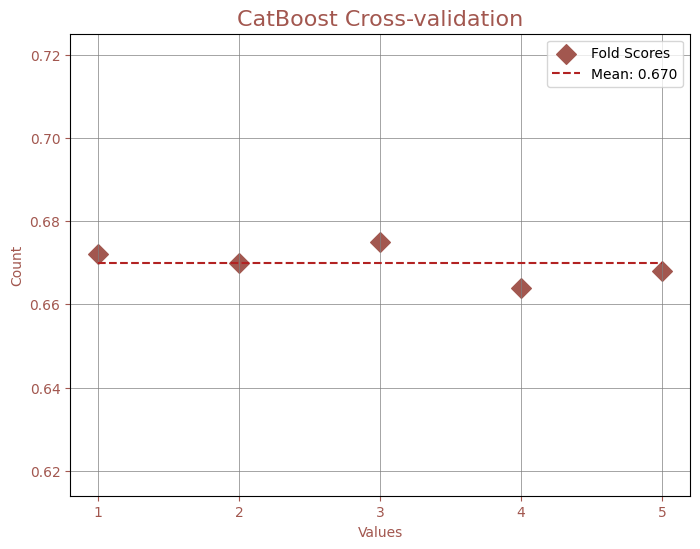

Overall Stratified C-Index Score for CatBoost: 0.6713


In [79]:
# 損失最小優先
cox2_models, cox2_oof_preds = md.train_model(CFG.cox2_params, target='target4', title='CatBoost')

In [80]:
cox1_preds = md.infer_model(test_data, cox1_models)

In [81]:
cox2_preds = md.infer_model(test_data, cox2_models)

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">アンサンブル</p>

In [82]:
oof_preds = [
    ctb1_oof_preds, 
    lgb1_oof_preds, 
    ctb2_oof_preds, 
    lgb2_oof_preds, 
    ctb3_oof_preds, 
    lgb3_oof_preds, 
    cox1_oof_preds,
    cox2_oof_preds
]

In [83]:
preds = [
    ctb1_preds, 
    lgb1_preds, 
    ctb2_preds, 
    lgb2_preds, 
    ctb3_preds, 
    lgb3_preds,
    cox1_preds,
    cox2_preds
]

<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">アンサンブル結果の精度評価</p>

In [84]:
# oof_preds（各予測モデル×）の中身について順位付け（値の小さい順）した結果を格納
ranked_oof_preds = np.array([rankdata(p) for p in oof_preds])

In [85]:
ensemble_oof_preds = np.dot(CFG.weights, ranked_oof_preds)

In [87]:
md.targets.validate_model(ensemble_oof_preds, 'Ensemble Model')

Overall Stratified C-Index Score for Ensemble Model: 0.6808


<p style="font-size: 125%; text-align: left; border-radius: 40px 40px;font-weight: bold;">テストデータの予測</p>

In [ ]:
ranked_preds = np.array([rankdata(p) for p in preds])

In [ ]:
ensemble_preds = np.dot(CFG.weights, ranked_preds)

In [ ]:
subm_data = pd.read_csv(CFG.subm_path)
subm_data['prediction'] = ensemble_preds

In [ ]:
subm_data.to_csv('submission.csv', index=False)
display(subm_data.head())